# 01 — Validation du dataset synthétique (Hôpital Pitié-Salpêtrière)

**Objectif :** valider la cohérence et l’exploitabilité du jeu de données synthétique simulant l’activité hospitalière (admissions, ressources, saisonnalité et événements).

Cette étape permet de vérifier :
1) la qualité des données (types, valeurs manquantes, doublons)  
2) la cohérence métier (ordres de grandeur par service, bornes)  
3) l’existence de patterns temporels (tendance/saisonnalité)  
4) l’impact des facteurs exogènes (hiver et événements)  
afin de justifier l’utilisation d’un modèle de prévision de type Prophet.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/synthetic/hospital_daily_activity.csv")
df["ds"] = pd.to_datetime(df["ds"])

## 1) Contrôles qualité (sanity checks)

On vérifie : dimensions, types, valeurs manquantes.
- `ds` doit être une date (pré-requis Prophet)
- aucune valeur manquante (ou justification/traitement si besoin)

In [14]:
df.shape
df.dtypes
df.isnull().sum()


ds               0
y                0
service          0
beds_occupied    0
staff_on_duty    0
is_winter        0
event            0
dtype: int64

## 2) Unicité et cohérence structurelle

Chaque ligne représente **un jour × un service**.  
On vérifie l’absence de doublons sur `(ds, service)` et la continuité temporelle par service.


In [29]:
# Doublons + continuité temporelle
dup = df.duplicated(subset=["ds", "service"]).sum()
print("Doublons (ds, service):", dup)

# Continuité temporelle ( Urgences)
df_u = df[df["service"] == "Urgences"].sort_values("ds")
delta_days = df_u["ds"].diff().dt.days.value_counts().sort_index()
delta_days.head(10)


Doublons (ds, service): 0


ds
1.0    2921
Name: count, dtype: int64

## 3) Cohérence métier (ordres de grandeur)

On valide que :
- les admissions sont ≥ 0
- les ordres de grandeur sont cohérents par service (Urgences > Cardiologie > Réanimation)
- les ressources restent dans des bornes réalistes


In [30]:
df.groupby("service")["y"].describe()


,count,mean,std,min,25%,50%,75%,max
service,,,,,,,,
Cardiologie,2922.0,65.582820,19.011920,5.0,52.25,65.0,77.0,141.0
Reanimation,2922.0,43.433265,16.487995,5.0,32.00,43.0,54.0,108.0
Urgences,2922.0,308.508214,54.317704,233.0,275.00,287.5,333.0,501.0


In [27]:
(df[df["service"]=="Urgences"]["beds_occupied"] == 200).mean()

np.float64(0.431895961670089)

In [ ]:
# Bornes et contrôles simples
cols = ["y", "beds_occupied", "staff_on_duty"]
display(df[cols].describe())

print("Min:\n", df[cols].min())
print("Max:\n", df[cols].max())


,y,beds_occupied,staff_on_duty
count,8766.000000,8766.000000,8766.000000
mean,139.174766,84.138604,126.156172
std,124.958478,71.657263,41.676692
min,5.000000,2.000000,72.000000
25%,47.000000,30.000000,84.000000
50%,68.000000,43.000000,119.000000
75%,275.000000,167.000000,171.000000
max,501.000000,200.000000,197.000000


Min:
 y                 5
beds_occupied     2
staff_on_duty    72
dtype: int64
Max:
 y                501
beds_occupied    200
staff_on_duty    197
dtype: int64


In [25]:
df_u = df[df["service"]=="Urgences"].sort_values("ds")
missing = df_u["ds"].diff().dt.days.value_counts().head()
missing

ds
1.0    2921
Name: count, dtype: int64

## 4) Patterns temporels (prédictibilité)

Objectif : vérifier que la série n’est pas du bruit pur.
On visualise :
- la série brute (Urgences)
- une moyenne mobile 30 jours (tendance/saisonnalité plus lisible)


In [17]:
df[["y", "beds_occupied", "staff_on_duty"]].min()
df[["y", "beds_occupied", "staff_on_duty"]].max()


y                501
beds_occupied    200
staff_on_duty    197
dtype: int64

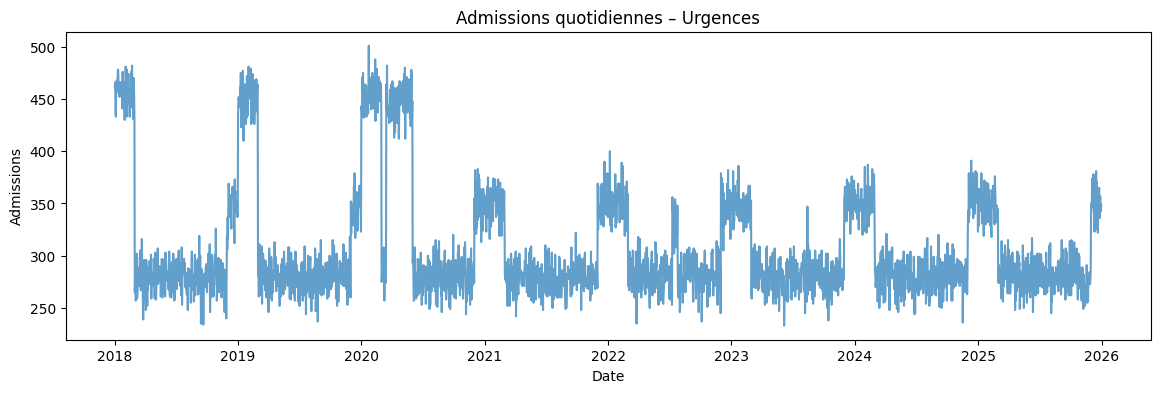

In [18]:
df_u = df[df["service"] == "Urgences"]

plt.figure(figsize=(14,4))
plt.plot(df_u["ds"], df_u["y"], alpha=0.7)
plt.title("Admissions quotidiennes – Urgences")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.show()


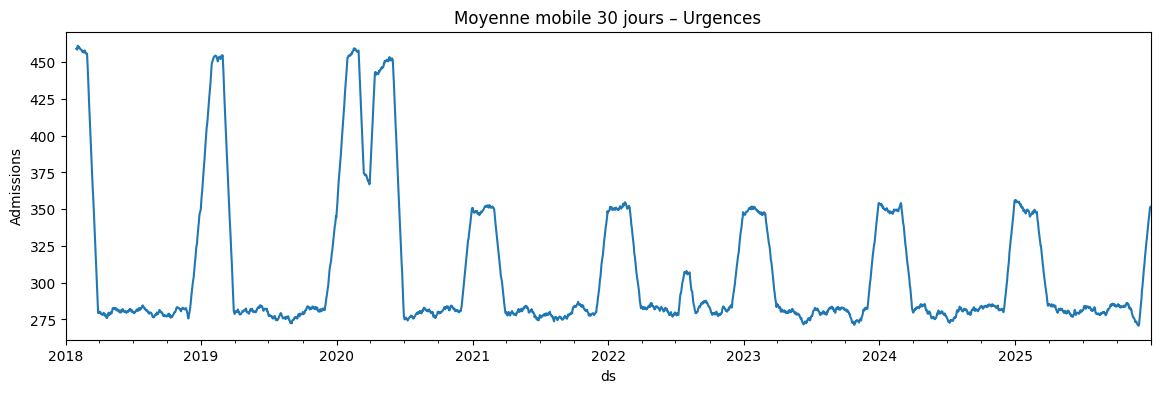

In [19]:
df_u.set_index("ds")["y"].rolling(30).mean().plot(figsize=(14,4))
plt.title("Moyenne mobile 30 jours – Urgences")
plt.ylabel("Admissions")
plt.show()


## 5) Facteurs exogènes : hiver et événements

On quantifie et visualise l’impact :
- **hiver vs hors hiver** (variable `is_winter`)
- **événements** (`flu`, `covid`, `heatwave`, `none`)

Ces facteurs servent à :
- expliquer les pics d’activité
- préparer des scénarios (épidémie, canicule)
- enrichir/interpréter les prévisions


In [20]:
df_u.groupby("is_winter")["y"].mean()


is_winter
0    286.454091
1    375.709141
Name: y, dtype: float64

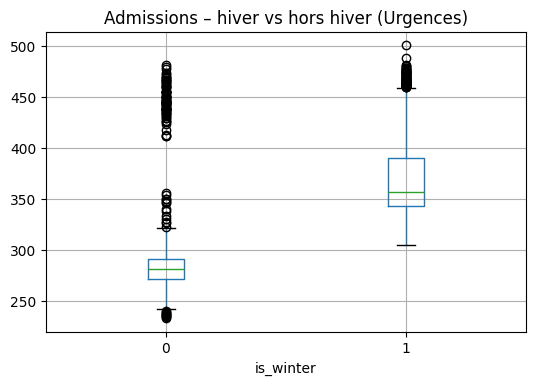

In [21]:
df_u.boxplot(column="y", by="is_winter", figsize=(6,4))
plt.title("Admissions – hiver vs hors hiver (Urgences)")
plt.suptitle("")
plt.show()


In [ ]:
# Répartition et impact des événements
display(df["event"].value_counts())

df_u.groupby("event")["y"].mean().sort_values()


event
none        7950
flu          534
covid        234
heatwave      48
Name: count, dtype: int64

event
none        294.413962
heatwave    332.625000
covid       447.692308
flu         455.179775
Name: y, dtype: float64

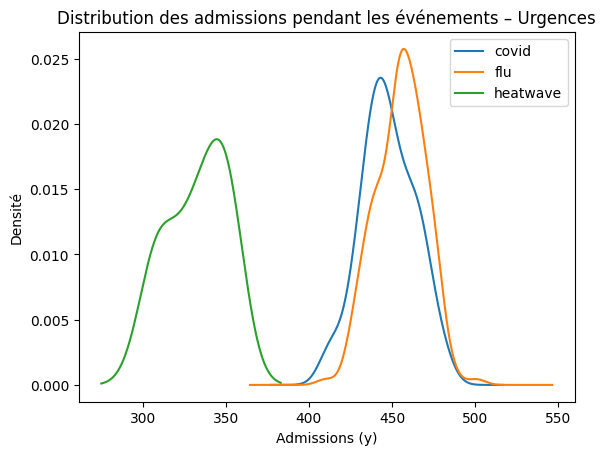

In [33]:
df_u[df_u["event"] != "none"].groupby("event")["y"].plot(kind="kde", legend=True)
plt.title("Distribution des admissions pendant les événements – Urgences")
plt.xlabel("Admissions (y)")
plt.ylabel("Densité")
plt.show()



In [ ]:
# Saturation lits
cap_urg = 200  
sat_rate = (df_u["beds_occupied"] == cap_urg).mean()
print(f"Taux de saturation lits Urgences (beds_occupied == {cap_urg}) : {sat_rate:.1%}")


Taux de saturation lits Urgences (beds_occupied == 200) : 43.2%
